In [16]:
# Styling
theme = 'seaborn-v0_8-whitegrid'
font = 'DejaVu Sans'

# Filters
property_filters = {
    'property_types': ['Apartamento']
}

# Files
json_file_path = "input/sectors-zn.json"
geojson_file_path = "input/sao_paulo-zn.geojson"

# Labels
price_bins = [0, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, float('inf')]
price_labels = [
    '<7k R$/m²', 
    '7-8k R$/m²', 
    '8-9k R$/m²', 
    '9-10k R$/m²', 
    '10-11k R$/m²', 
    '11-12k R$/m²',
    '12-13k R$/m²',
    '13-14k R$/m²',
    '14-15k R$/m²',
    '>15k R$/m²'
]
colors = [
    '#fcffa4',
    '#f7d13d',
    '#fb9b06',
    '#ed6925',
    '#cf4446',
    '#a52c60',
    '#781c6d',
    '#4a0c6b',
    '#1b0c41',
    '#000004'
]
title = "Preço Mediano do m²"
label_title = 'Preço mediano dos apartamentos (R$/m²)'
output_file_name = "output/sao_paulo_price_zn.png"

In [17]:
def process_property_data(json_path, filters=None):
    """
    Processes property data with configurable filters
    Args:
        json_path: Path to JSON data file
        filters: Dictionary of filter criteria
    """
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    sector_prices = []
    seen_properties = set()
    
    if filters is None:
        filters = {}
    
    for sector_id, sector_data in data.items():
        if not sector_data.get('ads'):
            continue
            
        prices = []
        for ad_group in sector_data['ads']:
            for ad in ad_group:
                prop = ad['_source']
                prop_id = prop['id']
                
                if prop_id in seen_properties:
                    continue
                seen_properties.add(prop_id)
                
                if not apply_filters(prop, filters):
                    continue
                    
                if not (prop.get('forSale') and prop.get('salePrice') and prop.get('area')):
                    continue
                    
                if prop['salePrice'] <= 0 or prop['area'] <= 0:
                    continue
                    
                price_per_m2 = prop['salePrice'] / prop['area']
                prices.append(price_per_m2)
        
        if prices:
            sector_prices.append({
                'CD_SETOR': sector_id,
                'median_price_m2': np.median(prices),
                'property_count': len(prices),
                'min_price': np.min(prices),
                'max_price': np.max(prices)
            })
    
    return pd.DataFrame(sector_prices)

def apply_filters(prop, filters):
    if 'property_types' in filters:
        if prop.get('type') not in filters['property_types']:
            return False
            
    return True

Processed 557 sectors with valid data


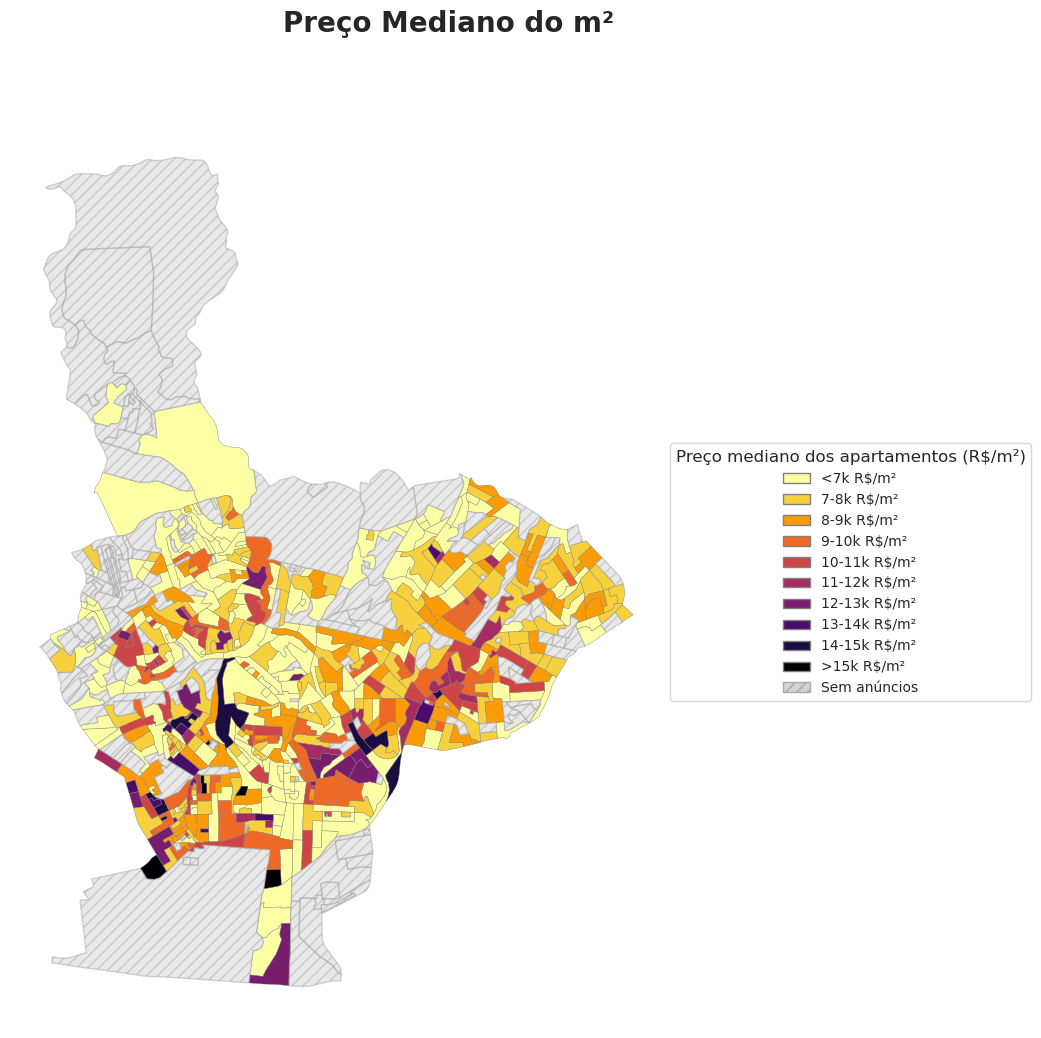

In [18]:
import json
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
import matplotlib as mpl

plt.style.use(theme)
mpl.rcParams['font.family'] = font

property_df = process_property_data(json_file_path, property_filters)
print(f"Processed {len(property_df)} sectors with valid data")

gdf = gpd.read_file(geojson_file_path)
merged = gdf.merge(property_df, on='CD_SETOR', how='left')

cmap = mpl.colors.ListedColormap(colors)

merged['price_category'] = pd.cut(
    merged['median_price_m2'],
    bins=price_bins,
    labels=price_labels,
    right=False,
    include_lowest=True
)

fig, ax = plt.subplots(1, figsize=(16, 12))

data_exists = merged.dropna(subset=['median_price_m2'])
if not data_exists.empty:
    for i, price_range in enumerate(price_labels):
        subset = data_exists[data_exists['price_category'] == price_range]
        if not subset.empty:
            subset.plot(
                color=colors[i],
                ax=ax,
                edgecolor='gray',
                linewidth=0.3,
                label=price_range
            )

no_data = merged[merged['median_price_m2'].isna()]
if not no_data.empty:
    no_data.plot(
        color='lightgrey',
        ax=ax,
        hatch='///',
        edgecolor='darkgrey',
        alpha=0.5,
        label='Sem anúncios'
    )

legend_elements = [
    Patch(facecolor=colors[i], edgecolor='gray', label=price_labels[i])
    for i in range(len(price_labels))
]

if not no_data.empty:
    legend_elements.append(
        Patch(facecolor='lightgrey', edgecolor='darkgrey', 
              hatch='///', label='Sem anúncios')
    )

ax.legend(
    handles=legend_elements,
    title=label_title,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=True,
    title_fontsize=12,
    fontsize=10
)

plt.figtext(0.5, 0.95, title, fontsize=20, ha='center', weight='bold')
ax.axis('off')
plt.tight_layout()
plt.subplots_adjust(top=0.88, bottom=0.12, right=0.85)
plt.savefig(output_file_name, dpi=300, bbox_inches='tight')
plt.show()